# Data Project 1


### Preamble

In [ ]:
# Standard librabries
import numpy as np
import pandas as pd

# APIs
from dstapi import DstApi
from fredapi import Fred

# Plotting libraries
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})
import matplotlib.dates as mdates

## Question 1

### 1.1. Basics

Using table PRIS113 from Denmark Statistics produce figures with, respectively,
1. The consumer price index (CPI), Pt, indexed to 100 on average in 2020
2. The month-to-month inflation rate, πt = Pt/Pt−1 − 1
3. The 12-month inflation rate, π12t = Pt/Pt−12 − 1

**The Consumer Price Index plot:**

The consumer price index plot uses data from DST, thus calling the DST API is the first step. The data is then cleaned and formatted to create a time series.

In [ ]:
# Calling API from DST
Pris113 = DstApi('PRIS113') 
# Getting a quick overview of the data
Pris113.tablesummary(language='en')
# Get parameters
params = Pris113.define_base_params(language='en') 
# Get data
df = Pris113.get_data(params=params, language='en')

#Setting up model
t = [c for c in df if c.lower() in ('tid','time')][0]                                       #Finding "Time" column in df
y = [c for c in df if c.lower() in ('indhold','value','obs_value','data')][0]               #Finding "Value" column in df
c = df[df['TYPE'].str.lower()=='consumer price index'].copy()                               #Compiling data for CPI only ("Time" and "Value" columns)
c['date'] = pd.to_datetime(c[t].str.replace('M','-') + '-01')                               #Creating date format column

P = pd.to_numeric(c[y]); P.index = c['date']; P = P.sort_index()                            #Creating time series P as our baseline for use throughout the project 
P

Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


date
1980-01-01     33.0
1980-02-01     33.3
1980-03-01     33.8
1980-04-01     34.0
1980-05-01     34.5
              ...  
2025-05-01    120.4
2025-06-01    120.7
2025-07-01    122.5
2025-08-01    121.7
2025-09-01    121.6
Name: INDHOLD, Length: 549, dtype: float64

When data is properly fetched and formatted, as shown above, we can proceed to plot the CPI indexed to 100 on average in 2020 and create the plot.

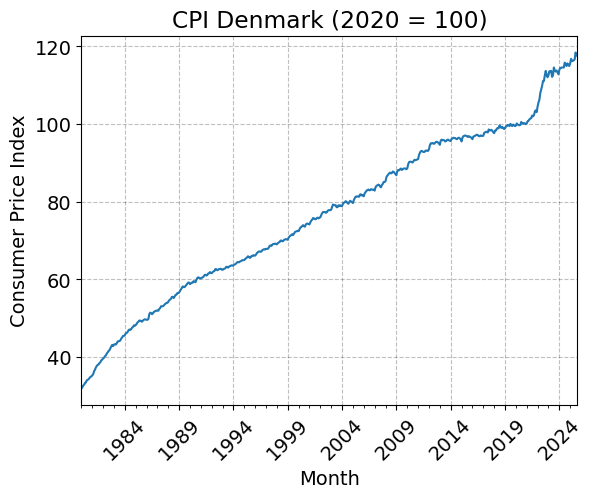

In [89]:
# Creating dataframe for plotting, indexing CPI to 100 in 2020
P_CPI = P * (100 / P[P.index.year==2020].mean())                 

# Creating plot 'CPI Denmark (2020=100)'
P_CPI.plot(title="CPI Denmark (2020 = 100)");                                                           
plt.xlabel("Month"); plt.ylabel("Consumer Price Index");
plt.xticks(rotation=45);
plt.show()

**Description of the CPI plot:**
The resulting plot shows CPI over time, indexed to 100 in 2020. The overall trend indicates a steady increase in consumer prices over the years, reflecting continuous inflationary pressures, with the most abrupt rise occurring in the months after 2020. Fluctuations occur on the somewhat steady trend until 2000, after which the CPI continues to rise but with more pronounced fluctuations. A significant spike is observed around 2021-2022, likely due to economic disruptions caused by the COVID-19 pandemic and subsequent recovery efforts. The CPI seems to stabilize itself to normal levels after this period, with more moderate increases, but also more fluctuations in comparison to pre-2000 levels.
The sudden spikes in fluctuations in the early 2000s and around 2021-2022 could be attributed to major economic events, such as the dot-com bubble burst and the global financial crisis in the early 2000s, and the COVID-19 pandemic in 2020-2021. These events likely caused significant disruptions in supply chains, changes in consumer behavior, and shifts in monetary policy, all of which can lead to increased volatility in consumer prices.

**Stationary Inflation Rate Plots:**

To create the month-to-month and 12-month inflation rate plots, we first compute the respective inflation rates from the CPI time series. The month-to-month inflation rate is calculated as the percentage change from one month to the next, while the 12-month inflation rate compares the current month's CPI to that of the same month in the previous year.

Starting off by creating indecies for the data, so that we can compute inflation rates easily with a '-1' and '-12' shift in the index

In [99]:
# Making indecies for the dataframe 'P_month'
P_month = P.reset_index()
P_month

,date,INDHOLD
0,1980-01-01,33.0
1,1980-02-01,33.3
2,1980-03-01,33.8
3,1980-04-01,34.0
4,1980-05-01,34.5
...,...,...
544,2025-05-01,120.4
545,2025-06-01,120.7
546,2025-07-01,122.5
547,2025-08-01,121.7


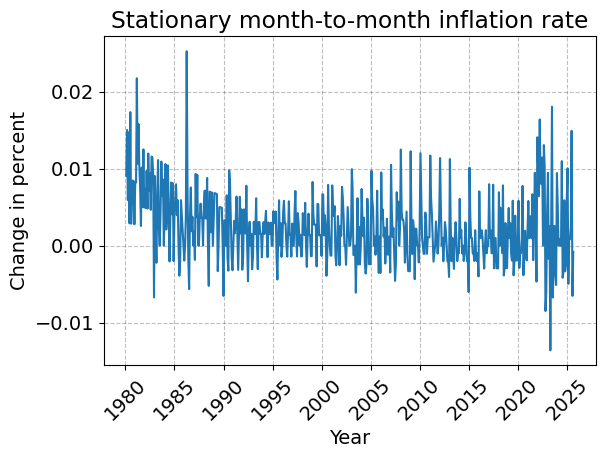

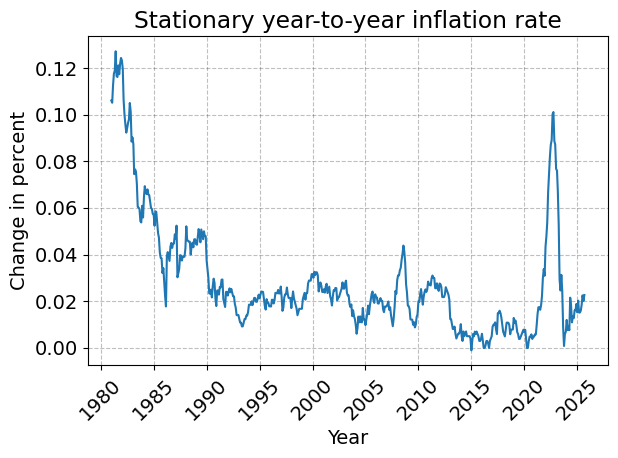

In [82]:
#Creating plot
# Setting up model for month-to-month inflation rate
pi = P_month['INDHOLD'].pct_change()


plt.plot(P_month['date'], pi)
plt.title('Stationary month-to-month inflation rate')
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Change in percent")
plt.tight_layout()
plt.show()

# Utilizing P_month for the monthly inflation rate, the yearly inflation rate is computed as:
P_year = P_month['INDHOLD'].pct_change(12)

plt.plot(P_month['date'], P_year)
plt.title("Stationary year-to-year inflation rate")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Change in percent")
plt.tight_layout()
plt.show()

**Description of the Inflation Rate plots:**
The month-to-month inflation rate plot reveals short-term fluctuations in consumer prices, with periods of both rising and falling inflation. Notably, there are sharp spikes in inflation rates around 1980 and 2022, most likely due to oil crises and the economic impact of the COVID-19 pandemic, respectively. The plot indicates that while inflation can be volatile in the short term, it generally hovers around a lower average rate over the long term.

The year-to-year inflation rate plot, on the other hand, smooths out these fluctuations by comparing each month's CPI to that of the same month in the previous year. This results in a more stable view of inflation trends, making it easier to identify long-term patterns.

### 1.2. Instantanious Inflation

For the instantaneous inflation rate, we implement a model that estimates inflation interference from recent data points using exponential smoothing. The model is defines as

$\pi_{t}^{12,\alpha} 
= \left( \prod_{k=0}^{11} \left( 1 + \pi_{t-k} \right)^{\kappa(k,\alpha)} \right) - 1,$

$\kappa(k,\alpha) = \frac{(T - k)^{\alpha}}{\displaystyle \sum_{j=0}^{T-1} (T - j)^{\alpha} \, T}.$

The model is set up using the baseline dataframe P, and we compute the instantaneous inflation rates for different values of alpha (0,1,2,3). The results are then plotted to visualize how the choice of alpha affects the estimated inflation rates.

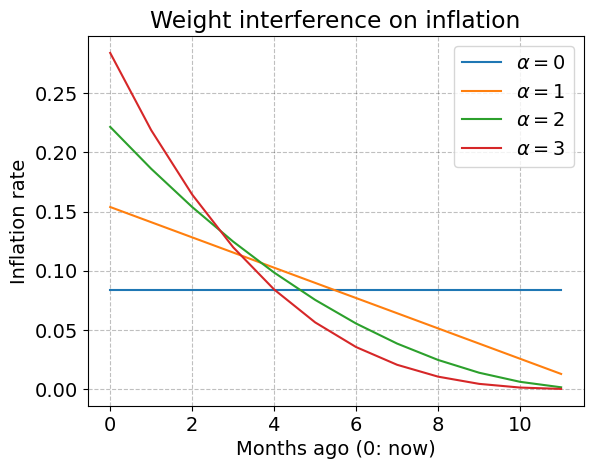

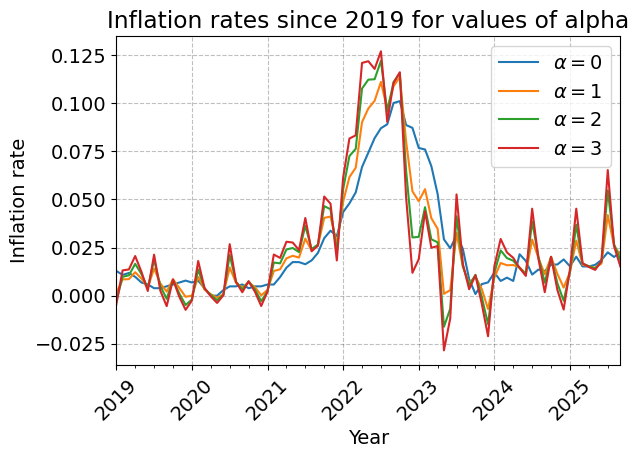

In [84]:
# Setting up weights: kappa(k, alpha) and the exponent
T = 12
k = np.arange(T)

def kappa(alpha):
    w = (T - k)**alpha
    w = w / w.sum()            
    return w                     

def exponents(alpha):
    return T * kappa(alpha)      

# Plotting kappa(k, alpha) for values of alpha
plt.figure()
for a in (0,1,2,3):
    plt.plot(k, kappa(a), label=fr'$\alpha={a}$')
plt.title('Weight interference on inflation')
plt.xlabel('Months ago (0: now)')
plt.ylabel('Inflation rate')
plt.legend()
plt.show()

# Computing instantaneous inflation function
def instantaneous_inflation(pi_series, alpha):
    e = exponents(alpha)
    def f(window):
        return np.prod((1.0 + window) ** e[::-1]) - 1.0
    return pi_series.rolling(T).apply(lambda w: f(w), raw=True)

# Calculating instantaneous inflation for alpha values
inst = {a: instantaneous_inflation(P_13_1, a) for a in (0,1,2,3)}

# Defining yearl inflation rate
P_inst = P.pct_change(12)  # P_t / P_{t-12} - 1


# Creating the plot
fig, ax = plt.subplots()
for a, s in inst.items():
    s.loc['2019':].plot(ax=ax, label=fr'$\alpha={a}$')
ax.set_title('Inflation rates since 2019 for values of alpha')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Description of the Instantaneous Inflation Rate plots:**
The plots display the instantaneous inflation rates calculated using the defined model for different values of alpha (0, 1, 2, 3). Each line represents the estimated inflation rate over time, highlighting how the choice of alpha influences the results. The plots help to visualize the impact of different weighting schemes on the inflation estimates.

The yearly inflation under influence from alpha is plotted alongside the instantaneous inflation rates to see the differences from the traditional yearly inflation calculation (where alpha = 0) and the instantaneous inflation model.

### 1.3. Core Inflation

In [117]:
Pris111 = DstApi('PRIS111')
params = Pris111.define_base_params(language='en')
df = Pris111.get_data(params=params, language='en')

I tried multiple approaches to calculate the core inflation, but I couldn't find a code that allowed me to withdraw specific categories from the CPI data fetched via the DST API.

### 1.4. Disaggregated inflation

## Question 2

### 2.1. CPI vs. HICP

This question compares the Consumer Price Index (CPI) with the Harmonized Index of Consumer Prices (HICP) to analyze their differences and similarities. The HICP is fetched from the Federal Reserve Economic Data (FRED) using the FRED API as seen below.

In [85]:
# Import FRED API key
fred = Fred(api_key="db9c8e25f99324194789f99eb26f0ce7") # <. here we set up the Fred API object

# define parameters / series we want to download
series = {
     "CP0000DKM086NEST":"hicp"
}

# use this code to download and store data
data = {}
for code,name in series.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

Downloaded CP0000DKM086NEST from FRED and saved it as hicp           


Since we only want to compare data from 2019 and onwards, we slice the data accordingly after fetching it.

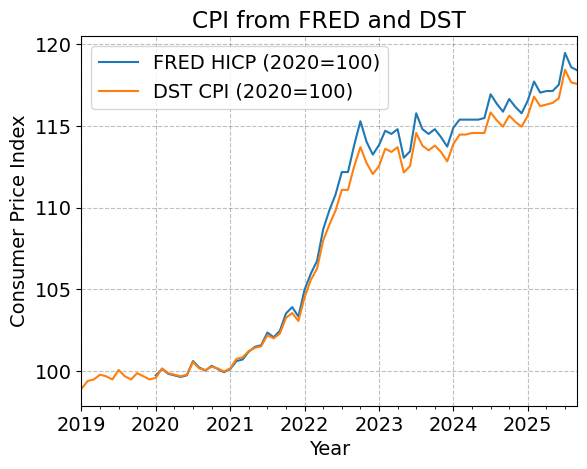

In [ ]:
# Data after 2019
data['hicp'] = data['hicp'][data['hicp'].index.year > 2019]
data['pris113_cpi'] = P_CPI[P_CPI.index.year > 2019]

# Choosing data from 2019
hicp = data['hicp'].loc['2019':].copy()
pris = P_CPI.loc['2019':].copy()

# Index FRED to mean 2020=100 to match DST CPI
hicp = hicp * (100 / hicp.loc['2020'].mean())

# Plotting series
pd.concat([
    hicp.rename('FRED HICP (2020=100)'),
    pris.rename('DST CPI (2020=100)')
], axis=1).plot(title="CPI from FRED and DST")
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')
plt.show()


**Description of the comparison plot:**
The comparison plot displays both the HICP and CPI from 2019 onwards, indexed to 100 in 2020. The indices are relatively comparable from 2019 to 2022, and the plot reveals that both indices generally follow similar trends, indicating that they capture comparable inflationary movements. However, the data disconverges from 2022 onwards, where the FRED HICP shows a more pronounced increase compared to the DST CPI.

### 2.2. Across countries

I tried to fetch HICP data for multiple countries using the FRED API, but I encountered difficulties in retrieving the data for Austria in particular.

## Question 3